In [67]:
# from google.colab import drive
# drive.mount('/content/drive')

# **HW 2: Classification**
In *homework 2*, you need to finish:

1.  Basic Part:

> *   Step 1: Load the input Data
> *   Step 2: Implement Naive Bayesian classifier
> *   Step 3: Build the classifier and check the correctness of Table building
> *   Step 4: Split Data
> *   Step 5: Make prediction and perform evaluation
> *   Step 6: Generate results

2.  Advanced Part:

> *   Step 1: Load the input Data
> *   Step 2: Implement Gaussian Naive Bayesian classifier
> *   Step 3: Build the classifier and check the correctness of Table building
> *   Step 4 Improve the classifier for Ranking
> *   Step 5: Make prediction and perform evaluation
> *   Step 6: Generate results

# **1. Basic Part (55%)**
In the first part, you need to implement the Naive Bayesian classifier:
- input features: ***9 physiological features***
- output prediction: ***hospital_death***

## *Import Packages*

> Note: You **cannot** import any other package

In [68]:
import numpy as np
import pandas as pd
import csv
import math
import random
import pickle

## Step 1: Load the input Data
Load the input file **hw2_basic_training.csv**

> Note: please don't change the input var name ***training_df, testing_df, X, and y***.

In [69]:
# TODO: modify your file path
training_df = pd.read_csv('hw2_basic_training.csv')
testing_df = pd.read_csv('hw2_basic_testing.csv')
y = training_df['hospital_death']
X = training_df.drop('hospital_death', axis=1)

you can take a look at the input feature & ground truth format:

In [70]:
X[:10]

,ventilated_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache
0,1,4,6,1,0,0,1,1,1
1,0,4,6,4,1,1,1,1,0
2,0,4,6,5,0,0,0,0,0
3,0,3,6,4,0,0,1,1,0
4,1,3,3,1,0,0,1,1,1
5,0,4,6,5,0,0,0,0,0
6,1,4,6,5,0,0,1,1,1
7,0,4,6,5,1,1,1,1,0
8,1,4,6,5,0,0,0,0,0
9,0,4,6,5,1,1,1,1,0


In [71]:
y[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: hospital_death, dtype: int64

## Step 2: Implement Naive Bayesian classifier
In this part, you need to implement the Naive Bayesian classifier. Since the data is categorical, you can refer to the L3-Bayesian Classifier course slides, p.12~16. The Bayes' theorem is as follows:

$$P(C|X) = \frac{P(X|C) \cdot P(C)}{P(X)}$$

We know that taking the logarithm of a series of multiplications can be transformed into a series of additions, making it easier to calculate. So, we can formulate it as follows by taking the logarithm of both sides:

$$\log(P(C|X)) = \log(P(X|C)) + \log(P(C)) - \log(P(X))$$

The term $\log(P(X))$ is a normalization constant that ensures the probabilities sum to 1 across all classes and is the same for all classes. Since it's constant during prediction for all classes, it doesn't affect class comparison. Therefore, in practice, you don't need to compute or include $\log(P(X))$ explicitly when comparing classes. Instead, you can focus on the relative values of the posterior probabilities.

So the **final equation** for implementation will be:
$$\log(P(C|X)) = \log(P(X|C)) + \log(P(C))$$

However, this equation may still encounter issues if the likelihood $P(X|C)$ equals 0, leading to an undefined $\log(P(X|C))$. To handle this exception, a simple way to avoid the issue is to assume the addition of one new record to the table to calculate the likelihood:

_likelihood = 1 / (len(self.feature_probs_table[c][feature]) + 1)


In [72]:
class NaiveBayes:
    def build_table(self, X, y):
        # classes for ground truth: there are only negative(0) and positive(1) for y (hospital_death)
        self.classes = np.unique(y)
        # record prior for two classes
        self.class_priors = {}
        # **feature_probs_table** is a 3D dictionary table:
        # structure: [class]    [feature]           [value] = probs
        # example:   [0]        ['gcs_eyes_apache'] [3]     = # of (hospital_death=0 && gcs_eyes_apache=3) / # of (hospital_death=0)
        # for more usage of python dict, you can refer to the link: https://www.w3schools.com/python/python_dictionaries.asp
        self.feature_probs_table = {}

        # consider negative(0) and positive(1) separately
        
        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / len(X) # TODO: calculate the prior
            self.feature_probs_table[c] = {}

            for feature in X.columns:
                self.feature_probs_table[c][feature] = {}
                for value in np.unique(X_c[feature]):
                    value_count = np.sum((X_c[feature] == value) & (y[y == c] == c)) # TODO: Calculate the count of data points with the current feature value and the current class
                    total_count = np.sum(y == c) # TODO: Calculate the total count of data points with the current feature within the current class
                    self.feature_probs_table[c][feature][value] = value_count / total_count # TODO: Calculate and store the conditional probability of the feature value given the class

    def predict(self, X):
        predictions = [self._predict(x) for x in X.to_dict(orient='records')]
        return predictions

    def _predict(self, x):
        log_posteriors = []

        # this for loop implement: log(posteior) = log(prior) + log(likelihood)
        for c in self.classes:
            log_prior = np.log(self.class_priors[c])
            log_likelihood = 0
            for feature, value in x.items():
                if value in self.feature_probs_table[c][feature]:
                    # you can look up the table for the likelihood
                    _likelihood = self.feature_probs_table[c][feature][value] # TODO: calculate likelihood by the self.feature_probs_table
                else:
                    # to fix issue of some cases not appear in the table
                    _likelihood = 1 / (len(self.feature_probs_table[c][feature]) + 1)
                log_likelihood += np.log(_likelihood)
            log_posterior = log_prior + log_likelihood
            log_posteriors.append((c, log_posterior))
        return max(log_posteriors, key=lambda x: x[1])[0] # TODO: Return the class with the highest logarithm of posterior probability as the predicted class


## Step 3: Build the classifier and check the correctness of Table building
You can easily build an instance of your classifier and then create the table.

To check whether you have correctly built the table of the Naive Bayesian classifier, there is an example for you to ensure that your implementation is correct.


In [73]:
# Create and build the dictionary table for Naive Bayes classifier
nb_classifier = NaiveBayes()
nb_classifier.build_table(X, y)

And you also need to output the dictionary variable ***feature_probs_table*** as a pickle file, which will be examined for correctness.
> Note: Since this is for checking the implementation of the build_table method, please ensure that the input for your table building, ***X and y,*** is taken from the provided hw2_basic_training.csv file ***BEFORE*** splitting the dataset into training and validation sets.

> Hint: Two values for you to check the implementation correctness:

> `nb_classifier.feature_probs_table[0]['gcs_eyes_apache'][3]` is
0.15299

> `nb_classifier.feature_probs_table[1]['gcs_eyes_apache'][3]` is
0.15896

In [74]:
if round(nb_classifier.feature_probs_table[0]['gcs_eyes_apache'][3], 5) == 0.15299 and \
   round(nb_classifier.feature_probs_table[1]['gcs_eyes_apache'][3], 5) == 0.15896:
    print('pass')
else:
    print('fail')

pass


In [75]:
# TODO: change your path to save the pickle file
pickle_file_path = 'hw2_basic_table'
with open(pickle_file_path, 'wb') as table_file:
    pickle.dump(nb_classifier.feature_probs_table, table_file)
    table_file.close()

## Step 4: Split Data
Split the data in *X, and y* into the training dataset and validation dataset.
> Note: You can use what you have implemented in hw1.

Since many students may not understand the meaning of a validation set, let's provide more explanation:

The purpose of a validation set is to determine whether our model is overfitting the training data.
- Underfitting: If the performance on the training set is poor (e.g., you haven't prepared enough for exam 1).
- Overfitting: If the performance on the training set is high, but the performance on the validation set is poor. (e.g., if you've focused solely on practicing with "past exam papers" (考古題) for exam 1, you might answer those questions correctly but struggle with new, unfamiliar questions during the actual exam).

If we achieve good performance on both the training set and the validation set, it indicates that the model has not only learned from the training data but also has the ability to make accurate inferences on unseen data.

![](https://hackmd.io/_uploads/SJLptEZWT.png)

Please split the dataset into training set and validation set

> Note: The purpose of ***random_state*** is to ensure that you can reproduce the results each time you split your dataset. This is often helpful for debugging.


In [76]:
def train_val_split(X, y, split_ratio = 0.8, random_state = 16):
    ... # TODO: implement your own train_val_split
    num_samples = len(X)

    random_state_ = np.random.RandomState(random_state)
    indices = np.arange(num_samples)
    random_state_.shuffle(indices)

    split_index = int(num_samples * split_ratio)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    train_indices.sort()
    val_indices.sort()
    X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]

    num_samples = len(y)

    random_state = np.random.RandomState(random_state)
    indices = np.arange(num_samples)
    random_state.shuffle(indices)

    split_index = int(num_samples * split_ratio)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    train_indices.sort()
    val_indices.sort()
    y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]
    return X_train, X_val, y_train, y_val

In [77]:
# TODO: Split the data into training and validation sets
# Note: please follow template for the format of return variables
print(len(X), len(y))
X_train, X_val, y_train, y_val = train_val_split(X, y) # TODO
print(len(X_train), len(X_val), len(y_train), len(y_val))

80000 80000
64000 16000 64000 16000


## Step 5: Make predictions and perform evaluation
The method we will evaluate the performance of the Bayesian classifier is ***F1-socre***:

$$\text{precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

$$F1\text{-}score = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

![](https://hackmd.io/_uploads/B1tfT9UWp.png)

Since the number of ground truth ***hospital_death*** where the outcome is positive is much less than the number of negative outcomes, we should focus on the f1-score of the positive class.

You need to implement the f1-score function to evaluate the performance of the Naive Bayesian classifier.

> Note: You should test your classifier by evaluating it on the training set and the validation set.


In [78]:
def cal_f1_score(y_true, y_pred):
    # Calculate True Positives, False Positives, False Negatives
    tp = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    fp = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 1) # TODO: calculate the false positive
    fn = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 0) # TODO: calculate the false negative
    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0 # TDOO: calculate the precision
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0 # TODO: calculate the recall

    # Calculate F1-score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0 # TODO: calculate the f1-score

    return f1_score
def cal_precision(y_true, y_pred):
    tp = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    fp = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 1) # TODO: calculate the false positive
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0 # TDOO: calculate the precision
    return precision
def cal_recall(y_true, y_pred):
    tp = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    fn = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 0) # TODO: calculate the false negative
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0 # TODO: calculate the recall
    return recall
def cal_FPR(y_true, y_pred):
    fp = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 1) # TODO: calculate the false positive
    tn = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 0)
    return fp/(fp+tn) if fp+tn > 0 else 0

In [79]:
# TODO: Build table on the training set
nb_classifier = NaiveBayes()
nb_classifier.build_table(X_train, y_train)

# TODO: Make predictions on the training set and calculate the f1-score
train_predictions = nb_classifier.predict(X_train)
train_f1_score = cal_f1_score(y_train, train_predictions)

# TODO: Make predictions on the validation set and calculate the f1-score
val_predictions = nb_classifier.predict(X_val)
val_f1_score = cal_f1_score(y_val, val_predictions)

# Print the F1-scores
print(f"Training F1-Score: {train_f1_score}")
print(f"Validation F1-Score: {val_f1_score}")

Training F1-Score: 0.3271651647520121
Validation F1-Score: 0.320364904749128


## Step 6: Generate result
> Note: Please follow the format mension in the slides, the can only change the path for saving your code down below.

In [80]:
predictions = nb_classifier.predict(testing_df) # TODO: predict on the testing_df

# TODO: Specify the CSV file path
csv_file_path = 'hw2_basic_prediction.csv'

# Write the predictions to the CSV file
with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['hospital_death'])
    for prediction in predictions:
        writer.writerow([prediction])

# **1. Advanced Part (40%)**
In advanced part, you need to implement the Gaussian Bayesian classifier:
- input features: ***3 physiological features***
- output prediction: ***diabetes_mellitus***

## Global attributes
> You can add your own global attributes here


## Step 1: Load the input Data
Load the input file **hw2_advanced_training.csv**
> Note: please don't change the input var name ***training_df, testing_df, X, and y***.

In [81]:
# TODO: modify your file path
training_df = pd.read_csv('hw2_advanced_training.csv')
testing_df = pd.read_csv('hw2_advanced_testing.csv')
y = training_df['diabetes_mellitus']
X = training_df.drop('diabetes_mellitus', axis=1)

In [82]:
X[:10]

,age,bmi,glucose_apache
0,64,40.808081,358.0
1,82,22.782294,183.0
2,54,19.651056,84.0
3,18,29.722807,89.0
4,46,24.404819,569.0
5,73,16.366843,267.0
6,63,26.386867,236.0
7,40,23.765104,89.0
8,58,47.528345,89.0
9,76,39.147070,193.0


In [83]:
y[:10]

0    1
1    0
2    0
3    0
4    1
5    1
6    1
7    1
8    0
9    1
Name: diabetes_mellitus, dtype: int64

you can check whether the standardization works

## Step 2: Implement Gaussian Naive Bayesian classifier
In this part, you need to implement the Gaussian Naive Bayesian classifier.

The main difference between Naive Bayesian and Gaussian Naive Bayesian is the likelihood part. For Gaussian NB, we can use the probability density function (PDF) of the ***Gaussian distribution*** (also known as the Normal distribution):

$$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} exp({-\frac{(x - \mu)^2}{2\sigma^2}})$$

The reason we need to use Gaussian is that when the data type is continuous numbers instead of discrete numbers, we can't build a table by just counting all the possible cases. However, we can assume the data distribution follows a Gaussian (or Normal) distribution by calculating its mean and variance. Then, we can approximate the values, even if some records don't appear in the training set.


In [84]:
class GaussianNaiveBayesian:
    def build_table(self, X, y):
        # classes for ground truth: there are only negative(0) and positive(1) for y (hospital_death)
        self.classes = np.unique(y)
        # record prior for two classes
        self.class_priors = {}
        # **feature_mean_var_table** is a 3D dictionary table:
        # structure: [class]    [feature]           ['mean'] = mean
        # structure: [class]    [feature]           ['var']  = var
        # example:   [0]        ['gcs_eyes_apache'] ['mean'] = mean for feature='gcs_eyes_apache' when hospital_death=0
        # example:   [0]        ['gcs_eyes_apache'] ['var']  = var for feature='gcs_eyes_apache' when hospital_death=0
        self.feature_mean_var_table = {}
        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = len(y[y == c]) / len(y) # TODO: calculate prior
            self.feature_mean_var_table[c] = {}
            for feature in X.columns:
                self.feature_mean_var_table[c][feature] = {}
                # Calculate mean and var for each feature
                self.feature_mean_var_table[c][feature]['mean'] = X_c[feature].mean() # TDOO: calculate the mean
                self.feature_mean_var_table[c][feature]['var'] = X_c[feature].var()  # TODO: calculate the var

    def _calculate_likelihood(self, x, mean, var):
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        return (1 / (np.sqrt(2 * np.pi * var))) * exponent
        # return ... # TODO: calculate the Gaussian (normal) distribution pdf function as likelihoo

    def predict(self, X):
        predictions = [self._predict(x) for x in X.to_dict(orient='records')]
        return predictions

    def _predict(self, x):
        log_posteriors = []
        # this for loop implement: log(posteior) = log(prior) + log(likelihood)
        for c in self.classes:
            log_prior = np.log(self.class_priors[c])
            log_likelihood = 0
            for feature, value in x.items():
                mean = self.feature_mean_var_table[c][feature]['mean']
                var = self.feature_mean_var_table[c][feature]['var']
                log_likelihood += np.log(self._calculate_likelihood(value, mean, var)) # TODO: calculate the log likelihood
            log_posterior = log_prior + log_likelihood
            log_posteriors.append((c, log_posterior))
        return max(log_posteriors, key=lambda x: x[1])[0]
        # return ... # TODO: Return the class with the highest logarithm of posterior probability as the predicted class


## Step 3: Build the classifier and check the correctness of Table building
You can easily build an instance of your classifier and then create the table.

To check whether you have correctly built the table of the ***Gaussian Naive Bayesian classifier***, there is an example for you to ensure that your implementation is correct.


In [85]:
# Initialize and build_table the model
gnb_classifier = GaussianNaiveBayesian()
gnb_classifier.build_table(X, y)

And you also need to output the dictionary variable ***feature_mean_var_table*** as a pickle file, which will be examined for correctness.
> Note: Since this is for checking the implementation of the build_table method, please ensure that the input for your table building, ***X and y,*** is taken from the provided hw2_advanced_training.csv file ***BEFORE*** splitting the dataset into training and validation sets.

> Hint: Two values for you to check the implementation correctness:


> `gnb_classifier.feature_mean_var_table[0]['bmi']['mean']` is
28.61544

> `gnb_classifier.feature_mean_var_table[0]['bmi']['var']` is
63.57263

In [86]:
# *** 10/18 update: the value of mean and var***
if round(gnb_classifier.feature_mean_var_table[0]['bmi']['mean'], 5) == 28.61544 and \
   round(gnb_classifier.feature_mean_var_table[0]['bmi']['var'], 5) == 63.57263:
    print('pass')
else:
    print('fail')

pass


In [87]:
# TODO: change your path to save the pickle file
pickle_file_path = 'hw2_advanced_table'
with open(pickle_file_path, 'wb') as table_file:
    pickle.dump(gnb_classifier.feature_mean_var_table, table_file)
    table_file.close()

## Step 4 Improve the classifier for Ranking 15%:

To make your model have better performance, you can try different ways to modify your model.

> hints (**you don't need to follow the hints**):

1. You can deal with the **outliers**
2. You can try first **converting real numbers into discrete values** and then using Naive Bayesian for classification.
3. You can try **def a new class for giving the prior a different weight** for decision-making.
4. Anything you want to try based on Bayesian.

> Note: You need to consider what kind of operations should also be performed on the testing_df.

In [88]:
class NaiveBayes:
    def __init__(self, m = 100000):
        self.m = m
    def build_table(self, X, y):
        # classes for ground truth: there are only negative(0) and positive(1) for y (hospital_death)
        self.classes = np.unique(y)
        # record prior for two classes
        self.class_priors = {}
        # **feature_probs_table** is a 3D dictionary table:
        # structure: [class]    [feature]           [value] = probs
        # example:   [0]        ['gcs_eyes_apache'] [3]     = # of (hospital_death=0 && gcs_eyes_apache=3) / # of (hospital_death=0)
        # for more usage of python dict, you can refer to the link: https://www.w3schools.com/python/python_dictionaries.asp
        self.feature_probs_table = {}

        # consider negative(0) and positive(1) separately
        # modified
        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = (len(X_c) + self.m/2) / (len(X) + self.m) # TODO: calculate the prior
            self.feature_probs_table[c] = {}

            for feature in X.columns:
                self.feature_probs_table[c][feature] = {}
                for value in np.unique(X_c[feature]):
                    value_count = np.sum((X_c[feature] == value) & (y[y == c] == c)) # TODO: Calculate the count of data points with the current feature value and the current class
                    total_count = np.sum(y == c) # TODO: Calculate the total count of data points with the current feature within the current class
                    self.feature_probs_table[c][feature][value] = value_count / total_count # TODO: Calculate and store the conditional probability of the feature value given the class

    def predict(self, X):
        predictions = [self._predict(x) for x in X.to_dict(orient='records')]
        return predictions

    def _predict(self, x):
        log_posteriors = []

        # this for loop implement: log(posteior) = log(prior) + log(likelihood)
        for c in self.classes:
            log_prior = np.log(self.class_priors[c])
            log_likelihood = 0
            for feature, value in x.items():
                if value in self.feature_probs_table[c][feature]:
                    # you can look up the table for the likelihood
                    _likelihood = self.feature_probs_table[c][feature][value] # TODO: calculate likelihood by the self.feature_probs_table
                else:
                    # to fix issue of some cases not appear in the table
                    _likelihood = 1 / (len(self.feature_probs_table[c][feature]) + 1)
                log_likelihood += np.log(_likelihood)
            log_posterior = log_prior + log_likelihood
            log_posteriors.append((c, log_posterior))
        return max(log_posteriors, key=lambda x: x[1])[0] # TODO: Return the class with the highest logarithm of posterior probability as the predicted class


In [89]:
# TODO: you can try the hints written above to get higher ranking score

training_df = pd.read_csv('hw2_advanced_training.csv') # TODO: modify your file path
testing_df = pd.read_csv('hw2_advanced_testing.csv') # TODO: modify your file path
# Note: **you can change the order of following steps if you want**
# Note: **BUT, please make sure you have saved 'hw2_advanced_table' for submission BEFORE making the following improvements.**

... # hints(optional): deal with outliers
... # hints(optional): converting real numbers into discrete values
... # hints(optional): def a new class for giving the prior a different weight
... # hints: Split the data into training and validation sets
... # hints: build table for Bayesian Classifier
... # anything you want to try based on Bayesian

Ellipsis

### Discretization
To apply the Naive Bayes Classifier, we begin by dividing each group into segments, each with a size of 5000.

In [90]:
def splitN(df, col, N = 5000):
    n = len(df)
    df_sorted = df.sort_values(by=col)
    df_sorted = df_sorted.reset_index(drop=True)
    boundaries = [df_sorted[col][0]]
    ind = N
    while ind < len(df_sorted):
        current_element = df_sorted[col][ind]
        boundaries.append(current_element)
        
        while ind+1 < n and current_element == df_sorted[col][ind+1]:
            ind += 1
        ind += N
    if boundaries[-1] != df_sorted[col][len(df_sorted)-1]:
        boundaries.append(df_sorted[col][len(df_sorted)-1])
    return boundaries
age_split = splitN(training_df, 'age')
bmi_split = splitN(training_df, 'bmi')
glucose_split = splitN(training_df, 'glucose_apache')
age_split


[16, 35, 46, 52, 57, 61, 65, 69, 73, 77, 81, 86, 89]

In [91]:
age_labels = ['[{}-{})'.format(start, end) for start, end in zip(age_split, age_split[1:])]
training_df['age' + '_category'] = pd.cut(training_df['age'], 
                                bins=age_split, 
                                labels=age_labels
                                )
bmi_labels = ['[{:0.2f}-{:0.2f})'.format(start, end) for start, end in zip(bmi_split, bmi_split[1:])]
training_df['bmi' + '_category'] = pd.cut(training_df['bmi'], 
                                bins=bmi_split, 
                                labels=bmi_labels
                                )
glucose_labels = ['[{}-{})'.format(start, end) for start, end in zip(glucose_split, glucose_split[1:])]
training_df['glucose_apache' + '_category'] = pd.cut(training_df['glucose_apache'], 
                                bins=glucose_split, 
                                labels=glucose_labels
                                )

In [92]:
training_df[['bmi_category', 'age_category', 'glucose_apache_category']]

,bmi_category,age_category,glucose_apache_category
0,[36.75-41.80),[61-65),[263.0-367.0)
1,[21.98-23.49),[81-86),[170.0-190.0)
2,[14.84-20.00),[52-57),[79.0-89.0)
3,[28.61-30.05),[16-35),[79.0-89.0)
4,[23.49-24.84),[35-46),[367.0-598.7)
...,...,...,...
64995,[26.05-27.34),[81-86),[96.0-104.0)
64996,[26.05-27.34),[69-73),[152.0-170.0)
64997,[23.49-24.84),[61-65),[79.0-89.0)
64998,[41.80-67.81),[35-46),[113.0-130.0)


Our Naive Bayesian classifier does not support string labels. To ensure compatibility and functionality, we must transform the categorical labels into integer values.

In [93]:
def transform_label(str_label, str_labels):
    int_labels = [i for i in range(len(str_labels))]
    return int_labels[str_labels.index(str_label)]

In [94]:
training_df['age_category_i'] = training_df['age_category'].apply(transform_label,
                                                                  str_labels = age_labels
                                                                  )
training_df['bmi_category_i'] = training_df['bmi_category'].apply(transform_label,
                                                                  str_labels = bmi_labels
                                                                  )
training_df['glucose_apache_category_i'] = training_df['glucose_apache_category'].apply(transform_label,
                                                                  str_labels = glucose_labels
                                                                  )

## Step 5: Make predictions and perform evaluation
You should test your model by evaluating the training set and validation set using the ***cal_f1_score*** function you implemented.


In [95]:
... # TODO: build table on the training set
... # TODO: Make predictions on training set and calculate the f1-score
... # TODO: Make predictions on validation set and calculate the f1-score
# TODO: Build table on the training set
import matplotlib.pyplot as plt
X_train = training_df[['bmi_category_i', 'age_category_i', 'glucose_apache_category_i']]
y_train = training_df['diabetes_mellitus']
X_train, X_val, y_train, y_val = train_val_split(X_train, y_train,
                                                 split_ratio=0.2,
                                                 random_state=2150)
nb_classifier = NaiveBayes(m = 74000)
nb_classifier.build_table(X_train, y_train)

train_predictions = nb_classifier.predict(X_train)
train_f1_score = cal_f1_score(y_train, train_predictions)

val_predictions = nb_classifier.predict(X_val)
val_f1_score = cal_f1_score(y_val, val_predictions)
print(f"Training F1-Score: {train_f1_score}")
print(f"Validation F1-Score: {val_f1_score}")
# for m in range(4000, 100000, 2000):
#     nb_classifier = NaiveBayes(m = m)
#     nb_classifier.build_table(X_train, y_train)

#     train_predictions = nb_classifier.predict(X_train)
#     train_f1_score = cal_f1_score(y_train, train_predictions)

#     val_predictions = nb_classifier.predict(X_val)
#     val_f1_score = cal_f1_score(y_val, val_predictions)
#     print(f"m = {m}, f1 = {val_f1_score}")
    # tpr = cal_recall(y_val, val_predictions)
    # fpr = cal_FPR(y_val, val_predictions)
    # tprs.append(tpr)
    # fprs.append(fpr)
    # Print the F1-scores

Training F1-Score: 0.5507096774193548
Validation F1-Score: 0.5604828298476633


In [96]:
age_f1 = []
age_precision = []
age_recall = []

bmi_f1 = []
bmi_precision = []
bmi_recall = []

glucose_f1 = []
glucose_precision = []
glucose_recall = []

val_pred_arr = np.array(val_predictions)

# Calculate metrics for age labels
for i in range(len(age_labels)):
    mask = X_val['age_category_i'] == i
    precision = cal_precision(y_val[mask], val_pred_arr[mask])
    recall = cal_recall(y_val[mask], val_pred_arr[mask])
    val_f1_score = cal_f1_score(y_val[mask], val_pred_arr[mask])

    age_f1.append(val_f1_score)
    age_precision.append(precision)
    age_recall.append(recall)

# Calculate F1 scores for BMI labels
for i in range(len(bmi_labels)):
    mask = X_val['bmi_category_i'] == i
    precision = cal_precision(y_val[mask], val_pred_arr[mask])
    recall = cal_recall(y_val[mask], val_pred_arr[mask])
    val_f1_score = cal_f1_score(y_val[mask], val_pred_arr[mask])

    bmi_f1.append(val_f1_score)
    bmi_precision.append(precision)
    bmi_recall.append(recall)

# Calculate F1 scores for glucose labels
for i in range(len(glucose_labels)):
    mask = X_val['glucose_apache_category_i'] == i
    precision = cal_precision(y_val[mask], val_pred_arr[mask])
    recall = cal_recall(y_val[mask], val_pred_arr[mask])
    val_f1_score = cal_f1_score(y_val[mask], val_pred_arr[mask])
    
    glucose_f1.append(val_f1_score)
    glucose_precision.append(precision)
    glucose_recall.append(recall)


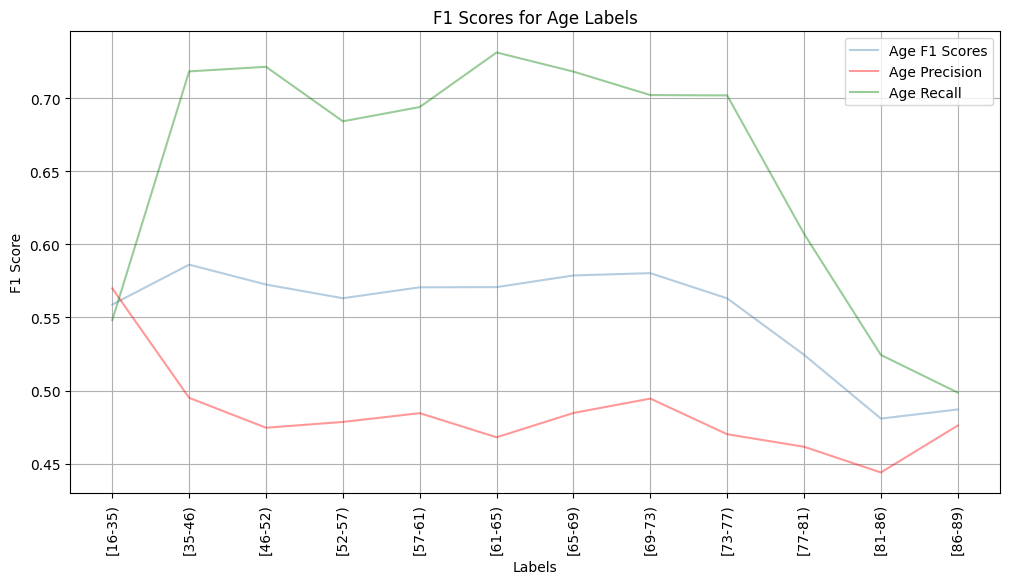

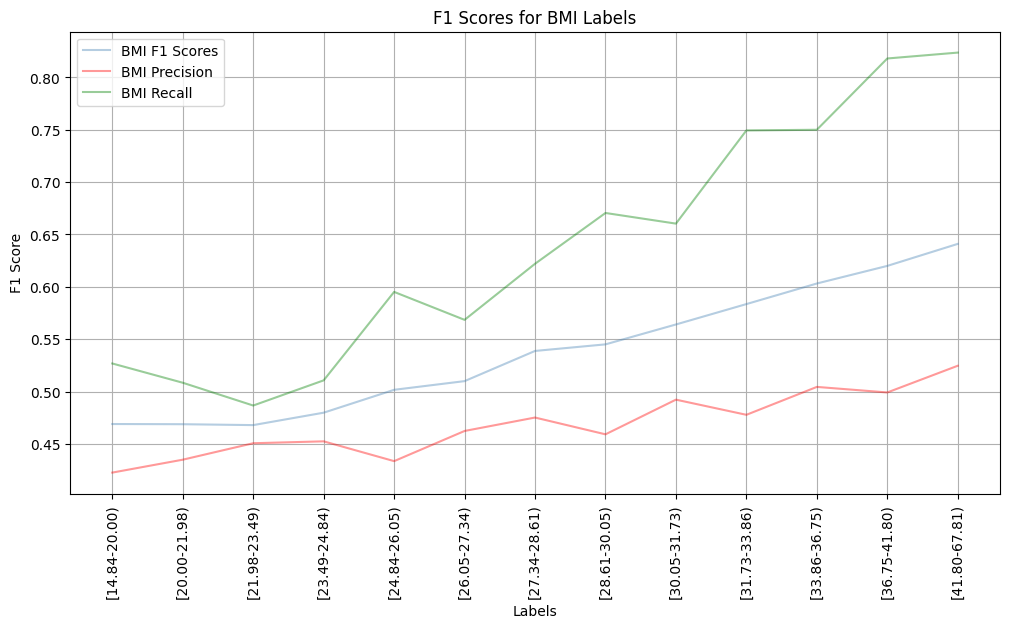

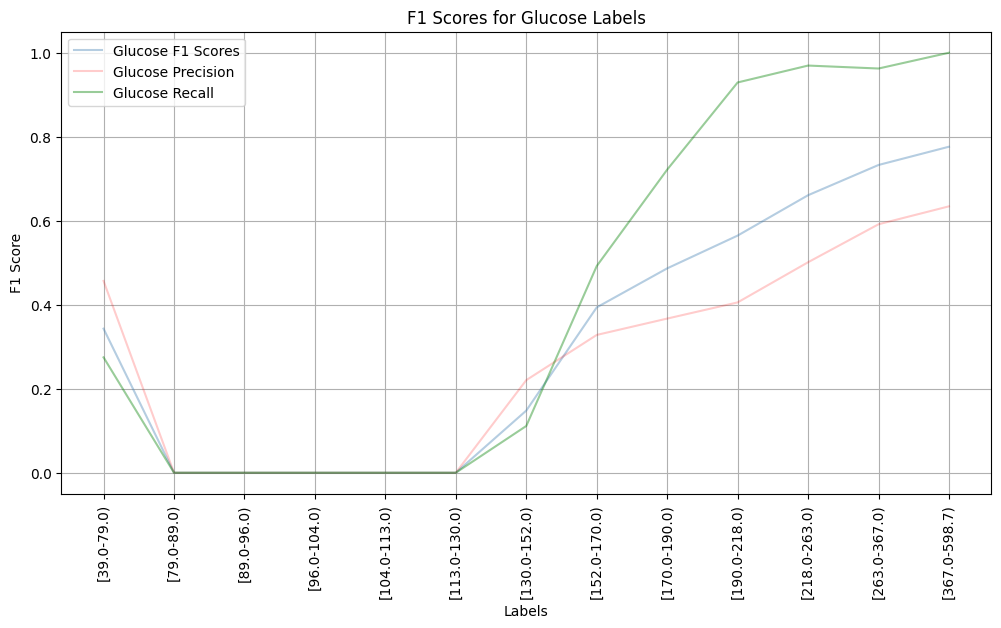

In [97]:
import matplotlib.pyplot as plt

# Plot age data
plt.figure(figsize=(12, 6))
plt.plot(age_labels, age_f1, color='steelblue',alpha=0.4, label='Age F1 Scores')
plt.plot(age_labels, age_precision, color='red',alpha=0.4 ,label='Age Precision')
plt.plot(age_labels, age_recall, color='green',alpha=0.4 , label='Age Recall')
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Age Labels')
plt.xticks(rotation=90)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Plot BMI data
plt.figure(figsize=(12, 6))
plt.plot(bmi_labels, bmi_f1, color='steelblue',alpha=0.4, label='BMI F1 Scores')
plt.plot(bmi_labels, bmi_precision, color='red', alpha=0.4, label='BMI Precision')
plt.plot(bmi_labels, bmi_recall, color='green',alpha=0.4, label='BMI Recall')
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('F1 Scores for BMI Labels')
plt.xticks(rotation=90)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Plot glucose data
plt.figure(figsize=(12, 6))
plt.plot(glucose_labels, glucose_f1, color='steelblue',alpha=0.4, label='Glucose F1 Scores')
plt.plot(glucose_labels, glucose_precision, color='red',alpha=0.2, label='Glucose Precision')
plt.plot(glucose_labels, glucose_recall, color='green',alpha=0.4, label='Glucose Recall')
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Glucose Labels')
plt.xticks(rotation=90)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Step 6: Generate result
> Note: Please follow the format mentioned in the slides. You can only change the path for saving your code down below.


In [98]:
age_split = splitN(testing_df, 'age')
bmi_split = splitN(testing_df, 'bmi')
glucose_split = splitN(testing_df, 'glucose_apache')
age_labels = ['[{}-{})'.format(start, end) for start, end in zip(age_split, age_split[1:])]
testing_df['age' + '_category'] = pd.cut(testing_df['age'], 
                                bins=age_split, 
                                labels=age_labels
                                )
bmi_labels = ['[{:0.2f}-{:0.2f})'.format(start, end) for start, end in zip(bmi_split, bmi_split[1:])]
testing_df['bmi' + '_category'] = pd.cut(testing_df['bmi'], 
                                bins=bmi_split, 
                                labels=bmi_labels
                                )
glucose_labels = ['[{}-{})'.format(start, end) for start, end in zip(glucose_split, glucose_split[1:])]
testing_df['glucose_apache' + '_category'] = pd.cut(testing_df['glucose_apache'], 
                                bins=glucose_split, 
                                labels=glucose_labels
                                )
testing_df['age_category_i'] = testing_df['age_category'].apply(transform_label,
                                                                  str_labels = age_labels
                                                                  )
testing_df['bmi_category_i'] = testing_df['bmi_category'].apply(transform_label,
                                                                  str_labels = bmi_labels
                                                                  )
testing_df['glucose_apache_category_i'] = testing_df['glucose_apache_category'].apply(transform_label,
                                                                  str_labels = glucose_labels
                                                                  )
X_test = training_df[['bmi_category_i', 'age_category_i', 'glucose_apache_category_i']]

In [99]:
predictions = nb_classifier.predict(X_test) # TODO: predict on the testing_df

# TODO: Specify the CSV file path
csv_file_path = 'hw2_advanced_prediction.csv'

# Write the predictions to the CSV file
with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['diabetes_mellitus'])
    for prediction in predictions:
        writer.writerow([prediction])

# Report *(5%)*

Report should be submitted as a pdf file **hw2_report.pdf**

* Briefly describe why we take log when implement the Bayesian classifier? (1%)
* Briefly describe the difference between Naïve Bayesian and Gaussian Naïve Bayesian classifier? (1%)
* Briefly describe the difficulty you encountered (1%)
* Summarize how you solve the difficulty and your reflections (2%)
* **No more than one page**

# Save the Code File
Please save your code and submit it as an ipynb file! (**hw2.ipynb**)

# Submission:
1. hw2_basic_prediction.csv
2. hw2_basic_table: **make sure you build_table BEFORE split train_val set, and pass the given example**
3. hw2_advanced_prediction.csv
4. hw2_advanced_table: **make sure you build_table BEFORE split train_val set or pre-processing, and pass the given example**
5. hw2.ipynb
6. hw2_report.pdf